# Road Line Pipeline

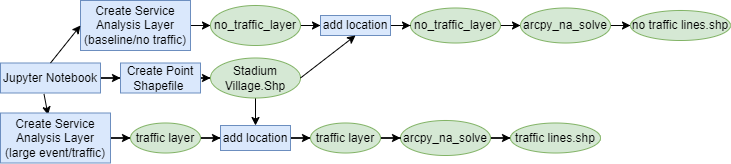

###### Credits:ChatGPT and Draw.io

## Imports

In [1]:
import arcpy
import os

## Set Path

In [2]:
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
arcpy.env.workspace = file_path

## Creating Data Point

In [3]:
#define location we would like to travel to from the events occuring
#coordinate intersection of Oak St and Washington Ave (longitude, latitude)
facility_coords = (-93.2265955, 44.9754918)
#putting coordinate into shapefile
shapefile_name = "Stadium_Village.shp"
#spatial reference (standard)
spatial_ref = arcpy.SpatialReference(4326)
#create the point shapefile -- creating feature class
dest_point = arcpy.CreateFeatureclass_management(arcpy.env.workspace, shapefile_name, "POINT", spatial_reference=spatial_ref)
#create a new insert cursor for adding the ppint/feature into shapefile/feature class
with arcpy.da.InsertCursor(shapefile_name, ["SHAPE@XY"]) as cursor:
    #add facility point
    cursor.insertRow([facility_coords])

## Creating Service Area Networks

In [4]:
#Create 2 seperate service area analysis layers given times 2
#analysis layer 1: No Traffic Baseline (Monday, July 10, 2023 at 2:00am)
##Output: Traffic analysis layer lines
no_traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name="No Traffic Baseline",
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day="7/10/2023 2:00:00 AM",
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)
#adding point destination location to the analysis layer 1
arcpy.na.AddLocations(
    in_network_analysis_layer=no_traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'No Traffic Baseline'>

In [5]:
#Analysis layer 2: traffic event (10/15/2023 12:30 PM; Volleyball; Williams Staduim)
#15 minutes before event started
event_time = "10/15/2023 12:15:00 PM"
name_event = "Large Event"

traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name=name_event,
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day=event_time,
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)
#adding point destination location to the analysis layer 1
arcpy.na.AddLocations(
    in_network_analysis_layer=traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'Large Event'>

## Solving Networks

In [6]:
#solve the network dataset-- creates lines
##THIS COSTS ESRI CREDITS
solved_no_traffic = arcpy.na.Solve(no_traffic_layer)

In [7]:
#solve the network dataset-- creates lines
##THIS COSTS ESRI CREDITS
solved_traffic = arcpy.na.Solve(traffic_layer)

## Exporting Lines

In [8]:
#extract the Service Area lines sublayer
#pulling lines out of No Traffic Baseline
no_traffic_sublayer = no_traffic_layer.getOutput(0)
no_traffic_sublayer = arcpy.na.GetNASublayer(no_traffic_sublayer, "SALines")
#export the service area polygons to a new shapefile
output_shapefile = "no_traffic_lines.shp"
arcpy.management.CopyFeatures(no_traffic_sublayer, output_shapefile)

#extract the Service Area lines sublayer
##pulling lines out of large Events
traffic_sublayer = no_traffic_layer.getOutput(0)
traffic_sublayer = arcpy.na.GetNASublayer(traffic_sublayer, "SALines")
#export the service area polygons to a new shapefile
output_shapefile = "traffic_lines.shp"
arcpy.management.CopyFeatures(traffic_sublayer, output_shapefile)

<Result 'C:\\Users\\Track\\OneDrive\\Documents\\ArcGIS\\Projects\\ArcIILab2\\traffic_lines.shp'>

## Quality Assurance Quality Control Pipeline
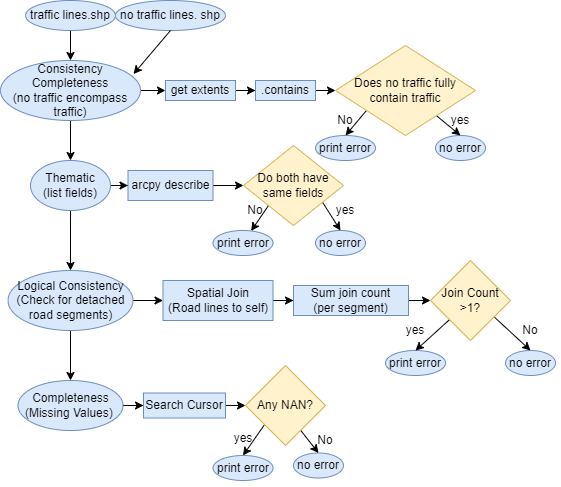

In [9]:
#variables
Road_Line_Baseline = no_traffic_sublayer
Road_Line_Event_Non_Baseline = traffic_sublayer
#completeness/logical consistency
#boundaries of both network datasets
baseline_extent = arcpy.Describe(Road_Line_Baseline).extent
event_extent = arcpy.Describe(Road_Line_Event_Non_Baseline).extent
#check if the baseline>than event
encompasses = (baseline_extent.contains(event_extent))
if encompasses:
    print("Baseline boundary is bigger than event boundary, than the data is good.")
else:
    print("Baseline boundary is smaller than event boundary, than the data is good.")

Baseline boundary is bigger than event boundary, than the data is good.


In [10]:
#list of fields for two Networks
#describe gets networks information
base_desc = arcpy.Describe(Road_Line_Baseline)
event_desc = arcpy.Describe(Road_Line_Event_Non_Baseline)
#list  all field names
base_field_names = [field.name for field in base_desc.fields]
event_field_names = [field.name for field in event_desc.fields]
#compare the fields
same_columns = set(base_field_names) == set(event_field_names)
print(f"Are columns the exact same? {same_columns}")

Are columns the exact same? True


In [11]:
#check if any little road segment is detached
def check_for_isolated_segments(input_dataset):
    #define the output dataset for the spatial join
    output_dataset = r"\ArcIILab2.gdb\temp_data"
    #spatial join
    arcpy.analysis.SpatialJoin(
    target_features=input_dataset,
    join_features=input_dataset,
    out_feature_class=output_dataset,
    join_operation="JOIN_ONE_TO_ONE",
    join_type="KEEP_ALL",
    field_mapping=r'FacilityID "FacilityID" true true true 4 Long 0 0,First,#,Large Event\Lines,FacilityID,-1,-1;SourceID "SourceID" true false true 4 Long 0 0,First,#,Large Event\Lines,SourceID,-1,-1;SourceOID "SourceOID" true false true 4 Long 0 0,First,#,Large Event\Lines,SourceOID,-1,-1;FromPosition "FromPosition" true false true 8 Double 0 0,First,#,Large Event\Lines,FromPosition,-1,-1;ToPosition "ToPosition" true false true 8 Double 0 0,First,#,Large Event\Lines,ToPosition,-1,-1;FromCumul_Minutes "FromCumul_Minutes" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Minutes,-1,-1;FromCumul_TravelTime "FromCumul_TravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TravelTime,-1,-1;FromCumul_Miles "FromCumul_Miles" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Miles,-1,-1;FromCumul_Kilometers "FromCumul_Kilometers" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Kilometers,-1,-1;FromCumul_TimeAt1KPH "FromCumul_TimeAt1KPH" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TimeAt1KPH,-1,-1;FromCumul_WalkTime "FromCumul_WalkTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_WalkTime,-1,-1;FromCumul_TruckMinutes "FromCumul_TruckMinutes" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TruckMinutes,-1,-1;FromCumul_TruckTravelTime "FromCumul_TruckTravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TruckTravelTime,-1,-1;ToCumul_Minutes "ToCumul_Minutes" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Minutes,-1,-1;ToCumul_TravelTime "ToCumul_TravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TravelTime,-1,-1;ToCumul_Miles "ToCumul_Miles" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Miles,-1,-1;ToCumul_Kilometers "ToCumul_Kilometers" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Kilometers,-1,-1;ToCumul_TimeAt1KPH "ToCumul_TimeAt1KPH" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TimeAt1KPH,-1,-1;ToCumul_WalkTime "ToCumul_WalkTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_WalkTime,-1,-1;ToCumul_TruckMinutes "ToCumul_TruckMinutes" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TruckMinutes,-1,-1;ToCumul_TruckTravelTime "ToCumul_TruckTravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TruckTravelTime,-1,-1;Shape_Length "Shape_Length" false true true 8 Double 0 0,First,#,Large Event\Lines,Shape_Length,-1,-1;FacilityID_1 "FacilityID" true true true 4 Long 0 0,First,#,Large Event\Lines,FacilityID,-1,-1;SourceID_1 "SourceID" true false true 4 Long 0 0,First,#,Large Event\Lines,SourceID,-1,-1;SourceOID_1 "SourceOID" true false true 4 Long 0 0,First,#,Large Event\Lines,SourceOID,-1,-1;FromPosition_1 "FromPosition" true false true 8 Double 0 0,First,#,Large Event\Lines,FromPosition,-1,-1;ToPosition_1 "ToPosition" true false true 8 Double 0 0,First,#,Large Event\Lines,ToPosition,-1,-1;FromCumul_Minutes_1 "FromCumul_Minutes" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Minutes,-1,-1;FromCumul_TravelTime_1 "FromCumul_TravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TravelTime,-1,-1;FromCumul_Miles_1 "FromCumul_Miles" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Miles,-1,-1;FromCumul_Kilometers_1 "FromCumul_Kilometers" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_Kilometers,-1,-1;FromCumul_TimeAt1KPH_1 "FromCumul_TimeAt1KPH" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TimeAt1KPH,-1,-1;FromCumul_WalkTime_1 "FromCumul_WalkTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_WalkTime,-1,-1;FromCumul_TruckMinutes_1 "FromCumul_TruckMinutes" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TruckMinutes,-1,-1;FromCumul_TruckTravelTime_1 "FromCumul_TruckTravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,FromCumul_TruckTravelTime,-1,-1;ToCumul_Minutes_1 "ToCumul_Minutes" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Minutes,-1,-1;ToCumul_TravelTime_1 "ToCumul_TravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TravelTime,-1,-1;ToCumul_Miles_1 "ToCumul_Miles" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Miles,-1,-1;ToCumul_Kilometers_1 "ToCumul_Kilometers" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_Kilometers,-1,-1;ToCumul_TimeAt1KPH_1 "ToCumul_TimeAt1KPH" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TimeAt1KPH,-1,-1;ToCumul_WalkTime_1 "ToCumul_WalkTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_WalkTime,-1,-1;ToCumul_TruckMinutes_1 "ToCumul_TruckMinutes" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TruckMinutes,-1,-1;ToCumul_TruckTravelTime_1 "ToCumul_TruckTravelTime" true true true 8 Double 0 0,First,#,Large Event\Lines,ToCumul_TruckTravelTime,-1,-1;Shape_Length_1 "Shape_Length" false true true 8 Double 0 0,First,#,Large Event\Lines,Shape_Length,-1,-1',
    match_option="INTERSECT",
    search_radius=None,
    distance_field_name=""
    )
    #summing up all the joins
    summary_table = arcpy.CreateUniqueName("JoinCountSummary.csv", arcpy.env.workspace)
    arcpy.analysis.Statistics(
    in_table=output_dataset,
    out_table=summary_table,
    statistics_fields="Join_Count SUM",
    case_field="TARGET_FID",
    concatenation_separator=""
    )
    #using search cursor finding any segments without join
    isolated_segments = [row[0] for row in arcpy.da.SearchCursor(summary_table, ["TARGET_FID"], "SUM_Join_Count = 1")]
    #clean up temporary datasets
    arcpy.Delete_management(output_dataset)
    arcpy.Delete_management(summary_table)
    # return list of isolated segment IDs
    return isolated_segments
#check for isolated segments
baseline_isolated_segments = check_for_isolated_segments(Road_Line_Baseline)
print("Baseline Dataset Isolated Segments:", baseline_isolated_segments)
event_isolated_segments = check_for_isolated_segments(Road_Line_Event_Non_Baseline)
print("Event Dataset Isolated Segments:", event_isolated_segments)

Baseline Dataset Isolated Segments: []
Event Dataset Isolated Segments: []


In [12]:
#checks any NAN values
def Missing_val(dataset, fields):
    missing_values = []
    for field in fields:
        with arcpy.da.SearchCursor(dataset, [field]) as cursor:
            for row in cursor:
                #going through evry row searching for missing values
                if row[0] is None:
                    #append the field name to the list
                    missing_values.append(field)
                    break  
    if not missing_values:
        return "No missing values."
    else:
        return f"Missing values: {missing_values}"
#calls function
fields_to_check = ["FromCumul_TravelTime", "FromCumul_Kilometers", "ToCumul_TravelTime", "ToCumul_Kilometers"]
print("No Traffic Baseline:", Missing_val(Road_Line_Baseline, fields_to_check))
print("Large Event:", Missing_val(Road_Line_Event_Non_Baseline, fields_to_check))

No Traffic Baseline: No missing values.
Large Event: No missing values.
